In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle
import math

from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet152
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,Input
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend, layers, models,utils
from keras.utils import multi_gpu_model
from keras_efficientnets.efficientnet import EfficientNetB3
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6457296416274395711
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7061687501
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12925183121015023492
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# 预处理

In [2]:
data_dir = './{}/'
nb_class = len(os.listdir(data_dir.format('train')))
data = {}
for i in ['train', 'valid']:
    data[i] = {x: os.listdir(data_dir.format(i)+x) for x in os.listdir(data_dir.format(i))}

检查两个数据集有没有重叠

In [3]:
print(any([data['valid']['cat'][x] in data['train']['cat'] for x in range(len(data['valid']['cat']))]))
print(any([data['valid']['dog'][x] in data['train']['dog'] for x in range(len(data['valid']['dog']))]))

False
False


## 图像变换

```python
datagen = {'train': image.ImageDataGenerator(
   preprocessing_function=preprocess_input,
#     rotation_range=20
#     ,width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True
#     ,vertical_flip=True
),
           'valid':image.ImageDataGenerator(
   preprocessing_function=preprocess_input
)
          }
```

或者简单写法：

In [4]:
datagen = {x: image.ImageDataGenerator(preprocessing_function=preprocess_input) for x in data.keys()}
datagen['train'].horizontal_flip = True

In [5]:
im_width, im_height = 224, 224
batch_size = 128

generator = {x: datagen[x].flow_from_directory(
    data_dir.format(x),
    target_size=(im_width, im_height),
    batch_size=batch_size,
    seed = 123,
    class_mode = 'binary',
    shuffle=True      
) for x in datagen.keys()}

generator['valid'].shuffle = False

Found 16662 images belonging to 2 classes.
Found 8208 images belonging to 2 classes.


## 载入模型

载入模型并排除顶部的全连接层。

In [6]:
# tf.reset_default_graph() 
# model_base = ResNet50(weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))

# model_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (im_width, im_height, 3))
model_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


添加自己的层：

In [7]:
model = Sequential()
model.add(model_base)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.75))
# model.add(Dense(500, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


或者这种写法：
```python
x = model_base.output
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5,)(x)
# x = Dense(500, activation='relu')(x)
# x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model_base.input, outputs=output)
```

查看冻结层前后的可训练层数：

In [8]:
print('Number of trainable weights befor freezing the model_base:', len(model.trainable_weights))
# for layer in model.layers[:173]:
#     layer.trainable = False
model_base.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model.trainable_weights))

Number of trainable weights befor freezing the model_base: 340
Number of trainable weights after freezing the model_base: 2


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1537      
Total params: 10,785,065
Trainable params: 1,537
Non-trainable params: 10,783,528
_________________________________________________________________


编译模型：

In [10]:
lr = 0.001
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=lr), metrics=["accuracy"])

## 训练模型

In [11]:
epochs = 20
history = model.fit_generator(generator['train'],
                              steps_per_epoch=math.ceil(generator['train'].samples / batch_size),
                              epochs=epochs,
                              validation_data=generator['valid'],
                              validation_steps=math.ceil(generator['valid'].samples / batch_size),
                              callbacks=[early_stopping],
                              verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 73s - loss: 0.4318 - acc: 0.8062 - val_loss: 5.3870 - val_acc: 0.5022
Epoch 2/20
 - 67s - loss: 0.2852 - acc: 0.8878 - val_loss: 5.7061 - val_acc: 0.5029
Epoch 3/20
 - 67s - loss: 0.2550 - acc: 0.8965 - val_loss: 5.9279 - val_acc: 0.5016
Epoch 4/20
 - 67s - loss: 0.2464 - acc: 0.8983 - val_loss: 6.1127 - val_acc: 0.4991
Epoch 5/20
 - 67s - loss: 0.2397 - acc: 0.8998 - val_loss: 6.1263 - val_acc: 0.5016
Epoch 6/20
 - 67s - loss: 0.2440 - acc: 0.8990 - val_loss: 6.2287 - val_acc: 0.4984


保存模型checkpoint：

In [12]:
model.save_weights('model_binary_wieghts.h5')
model.save('model_binary.h5')

# 重新载入模型

In [13]:
# model = load_model('model_binary.h5')

## 可视化

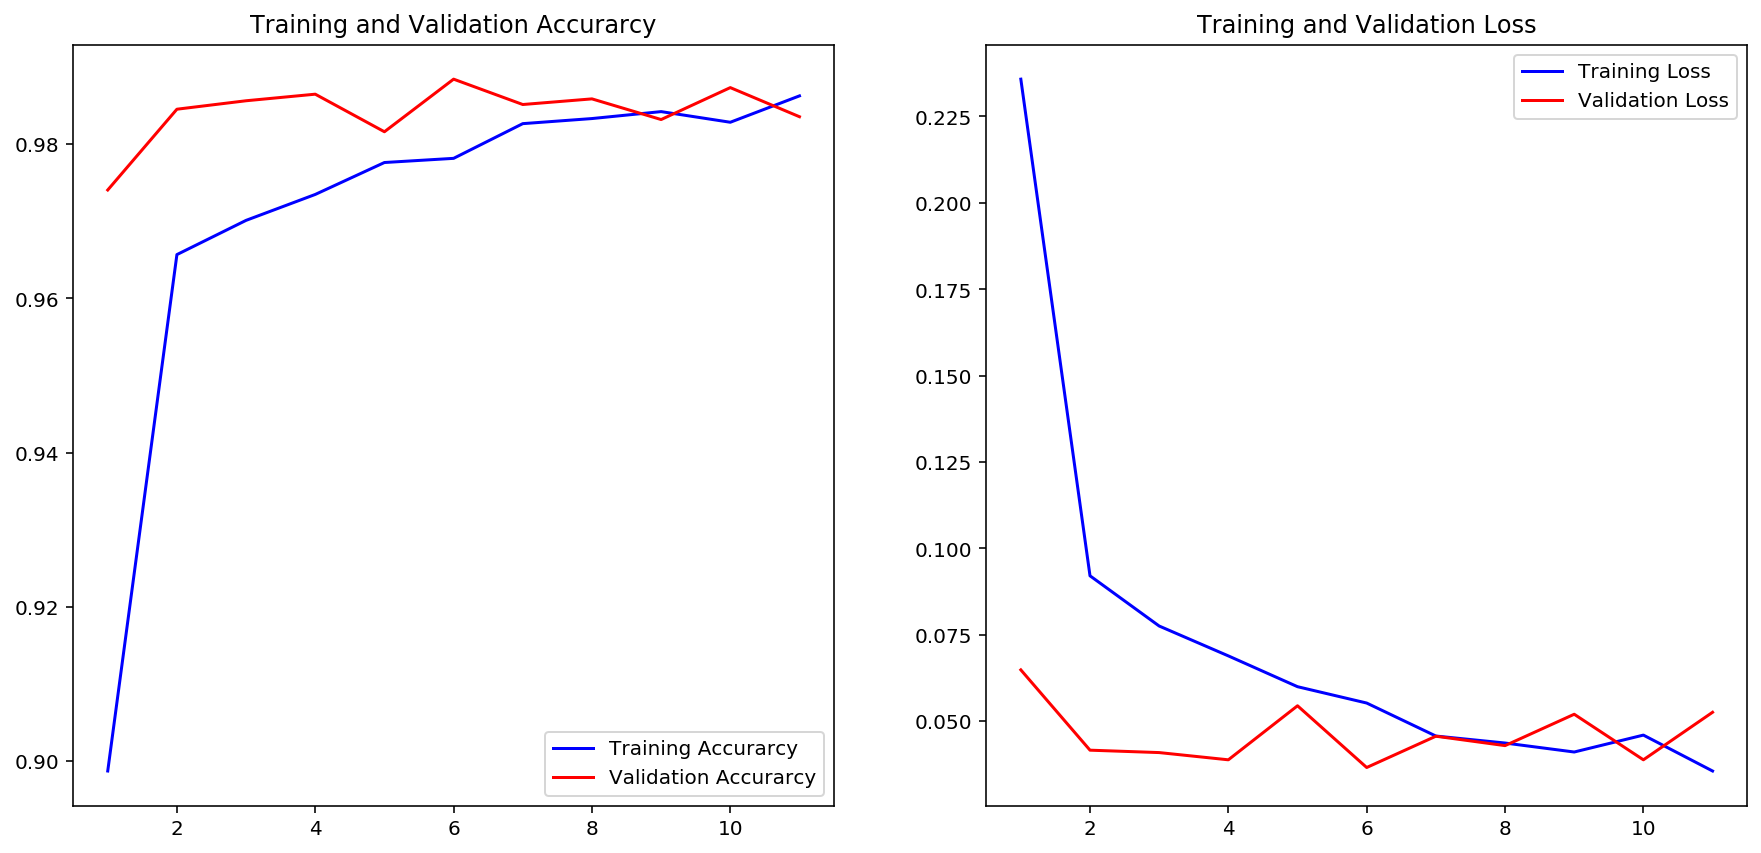

In [14]:
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.figure(figsize = [15, 7])
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'blue', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'red', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.legend()

plt.subplot(1,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss and acc.jpg', bbox_inches = 'tight')
plt.show()

# 预测

In [ ]:
test_imgs = os.listdir(data_dir.format('test'))
img_path = data_dir.format('test') + test_imgs[3]
# img_path = './test04.jpg'
img = image.load_img(img_path, target_size=(im_width, im_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)[0][0]
print(preds)
img_show = mpimg.imread(img_path)
plt.imshow(img_show)
plt.suptitle('This is a {}'.format('dog' if preds > 0.5 else 'cat'))
plt.title('probability: {}%'.format(round(preds, 3)*100) if preds > 0.5 else round(1-preds, 3)*100);

全部预测，制作csv表

In [ ]:
test_imgs = os.listdir(data_dir.format('test'))
ids = []
label = []
for i in tqdm(test_imgs):
    img = image.load_img(data_dir.format('test') + i, target_size=(im_width, im_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    label.append(model.predict(x)[0][0])
    ids.append(int(i.split('.')[0]))

In [ ]:
sub = pd.DataFrame({'id': ids, 'label': label}).sort_values('id',axis = 0, ascending = True)
sub.to_csv('submission.csv', index = False)

# 参考资料

+ https://zhuanlan.zhihu.com/p/26693647
+ https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
+ https://www.kaggle.com/risingdeveloper/transfer-learning-in-keras-on-dogs-vs-cats